In [12]:
# Enhanced Dental Practice Valuation Q&A Pipeline
# With Productivity and Procedures Data Integration

# ============================================================================
# CELL 1: Import Required Libraries
# ============================================================================

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import requests
from typing import Dict, List, Optional, Tuple, Any
import warnings
import re
from datetime import datetime
import os
warnings.filterwarnings('ignore')

# Set style for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully!")

Libraries imported successfully!


In [13]:
# ============================================================================
# CELL 2: Configuration and API Setup
# ============================================================================

# OpenRouter API Configuration
OPENROUTER_API_KEY = "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"  # Replace with actual key
OPENROUTER_URL = "https://openrouter.ai/api/v1/chat/completions"

# Model selection (free tier)
MODEL = "deepseek/deepseek-chat-v3-0324:free"  # Free model

# Headers for API requests
headers = {
    "Authorization": f"Bearer {OPENROUTER_API_KEY}",
    "Content-Type": "application/json",
    "HTTP-Referer": "http://localhost:3000",
    "X-Title": "Dental Practice Valuation Q&A"
}

print(f"API configured with model: {MODEL}")

API configured with model: deepseek/deepseek-chat-v3-0324:free


In [31]:
# ============================================================================
# CELL 3: Enhanced Data Loading and Validation Functions
# ============================================================================

class DentalPracticeData:
    """Enhanced class to handle dental practice data from multiple sources"""
    
    def __init__(self, json_file_path: Optional[str] = None, 
                 productivity_csv: Optional[str] = None,
                 procedures_csv: Optional[str] = None,
                 data_dict: Optional[Dict] = None):
        """
        Initialize with JSON data and optional CSV files
        
        Args:
            json_file_path: Path to JSON file with financial data
            productivity_csv: Path to productivity CSV file
            procedures_csv: Path to procedures CSV file
            data_dict: Direct dictionary input (alternative to file)
        """
        # Load base financial data
        if json_file_path:
            with open(json_file_path, 'r') as f:
                self.data = json.load(f)
        elif data_dict:
            self.data = data_dict
        else:
            raise ValueError("Must provide either json_file_path or data_dict")
        
        # Load productivity data if provided
        self.productivity_data = None
        if productivity_csv:
            self.productivity_data = self._load_productivity_data(productivity_csv)
            
        # Load procedures data if provided
        self.procedures_data = None
        if procedures_csv:
            self.procedures_data = self._load_procedures_data(procedures_csv)
            
        # Validate and calculate metrics
        self._validate_required_fields()
        self._calculate_derived_metrics()
        self._add_simulated_data()
        
    def _load_productivity_data(self, csv_path: str) -> pd.DataFrame:
        """Load and process productivity CSV data"""
        try:
            df = pd.read_csv(csv_path)
            
            # Handle column name variations
            # Rename provider_name to provider for consistency
            if 'provider_name' in df.columns and 'provider' not in df.columns:
                df = df.rename(columns={'provider_name': 'provider'})
            
            # Print actual columns for debugging
            print(f"Productivity CSV columns: {list(df.columns)}")
            
            # Clean numeric columns
            numeric_cols = ['patients_seen', 'avg_visit_fee', 'production', 
                           'collection', 'adjustments']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col].astype(str).str.replace('$', '').str.replace(',', ''), errors='coerce')
            
            print(f"Loaded productivity data: {len(df)} records")
            return df
        except Exception as e:
            print(f"Error loading productivity data: {e}")
            return None
    
    def _load_procedures_data(self, csv_path: str) -> pd.DataFrame:
        """Load and process procedures CSV data with regex cleaning"""
        try:
            df = pd.read_csv(csv_path)
            
            # Print actual columns for debugging
            print(f"Procedures CSV columns: {list(df.columns)}")
            
            # Clean service names using regex patterns
            if 'service' in df.columns:
                # Common cleaning patterns
                df['service_clean'] = df['service'].apply(self._clean_service_name)
                
                # Categorize services
                df['service_category'] = df['service_clean'].apply(self._categorize_service)
            
            # Clean numeric columns
            numeric_cols = ['number', 'amount']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col].astype(str).str.replace('$', '').str.replace(',', ''), errors='coerce')
            
            print(f"Loaded procedures data: {len(df)} records")
            return df
        except Exception as e:
            print(f"Error loading procedures data: {e}")
            return None
    
    def _clean_service_name(self, service: str) -> str:
        """Clean service names using regex patterns"""
        if pd.isna(service):
            return "Unknown"
        
        service = str(service).strip()
        
        # Common patterns to clean
        patterns = [
            (r'^D\d{4}\s*-?\s*', ''),  # Remove procedure codes at start
            (r'\s+', ' '),  # Multiple spaces to single
            (r'[^\w\s-]', ''),  # Remove special characters except dash
            (r'^\s*-\s*', ''),  # Remove leading dashes
        ]
        
        for pattern, replacement in patterns:
            service = re.sub(pattern, replacement, service)
        
        # Standardize common terms
        replacements = {
            'xray': 'X-Ray',
            'x ray': 'X-Ray',
            'bitewing': 'Bitewing',
            'bw': 'Bitewing',
            'prophy': 'Prophylaxis',
            'exam': 'Examination',
            'perio': 'Periodontal',
        }
        
        service_lower = service.lower()
        for old, new in replacements.items():
            if old in service_lower:
                service = service.replace(service_lower, service_lower.replace(old, new.lower()))
                service = service.title()
                break
        
        return service if service else "Unknown"
    
    def _categorize_service(self, service: str) -> str:
        """Categorize services into major groups"""
        service_lower = service.lower()
        
        categories = {
            'Diagnostic': ['exam', 'x-ray', 'bitewing', 'panoramic', 'consult'],
            'Preventive': ['prophy', 'clean', 'fluoride', 'sealant'],
            'Restorative': ['filling', 'crown', 'bridge', 'composite', 'amalgam'],
            'Endodontic': ['root canal', 'endo', 'pulp'],
            'Periodontal': ['perio', 'scaling', 'root planing', 'gum'],
            'Oral Surgery': ['extraction', 'surgery', 'implant'],
            'Prosthodontic': ['denture', 'partial', 'prosth'],
            'Orthodontic': ['ortho', 'braces', 'aligner'],
        }
        
        for category, keywords in categories.items():
            if any(keyword in service_lower for keyword in keywords):
                return category
        
        return 'Other'
    
    def _add_simulated_data(self):
        """Add simulated data for demonstration purposes"""
        # Add location data (simulated)
        self.data['Location_Analysis'] = {
            'address': self.data.get('Practice_Overview', {}).get('Location', 'Unknown'),
            'demographics': {
                'population_5mi': 45000,
                'median_income': 75000,
                'growth_rate': '2.3%',
                'competitor_density': 'Medium (8 practices within 5mi)'
            },
            'accessibility_score': 8.5,  # Out of 10
            'visibility_score': 7.0,
            'parking_availability': 'Excellent',
            'public_transit': 'Good'
        }
        
        # Add staffing metrics (simulated)
        self.data['Staffing_Metrics'] = {
            'hygienist_ratio': 2.5,  # Hygienists per dentist
            'total_staff': 12,
            'overtime_percentage': 8.5,
            'staff_utilization': 85,
            'turnover_rate': 15,
            'satisfaction_score': 4.2  # Out of 5
        }
        
        # Add survey data (simulated)
        self.data['Survey_Data'] = {
            'patient_satisfaction': {
                'overall': 4.5,
                'wait_time': 4.2,
                'staff_friendliness': 4.7,
                'treatment_quality': 4.6,
                'value_for_money': 4.1
            },
            'doctor_feedback': {
                'equipment_quality': 'Modern and well-maintained',
                'practice_efficiency': 'Good, room for improvement in scheduling',
                'growth_potential': 'High - underserved pediatric market',
                'main_challenges': 'Staff retention, increasing competition'
            }
        }
        
        # Add P&L verification flags (simulated)
        self.data['Financial_Verification'] = {
            'p_and_l_verified': True,
            'verification_method': 'Bank statements and tax returns',
            'discrepancies_found': 'Minor - adjusted depreciation',
            'confidence_level': 'High (95%)'
        }
    
    def _validate_required_fields(self):
        """Validate that core required fields are present"""
        required_fields = ['Revenue_Trailing12', 'EBITDA_Trailing12']
        
        for field in required_fields:
            if field not in self.data:
                # Try to calculate from other data if possible
                if field == 'EBITDA_Trailing12' and 'Total_SDE' in self.data:
                    self.data['EBITDA_Trailing12'] = self.data['Total_SDE'] * 1.2
                else:
                    print(f"Warning: {field} not found in data")
    
    def _calculate_derived_metrics(self):
        """Calculate additional metrics from the data"""
        # Existing calculations
        if 'Revenue_Trailing12' in self.data and 'EBITDA_Trailing12' in self.data:
            self.data['EBITDA_Margin'] = (self.data['EBITDA_Trailing12'] / 
                                          self.data['Revenue_Trailing12']) * 100
        
        if 'Total_SDE' in self.data and 'Revenue_Trailing12' in self.data:
            self.data['SDE_Margin'] = (self.data['Total_SDE'] / 
                                       self.data['Revenue_Trailing12']) * 100
        
        # Calculate DSCR if debt service is available
        if 'Debt_Service_Annual' in self.data and 'EBITDA_Trailing12' in self.data:
            self.data['DSCR'] = self.data['EBITDA_Trailing12'] / self.data['Debt_Service_Annual']
        
        # Calculate productivity metrics if data available
        if self.productivity_data is not None and not self.productivity_data.empty:
            # Summary statistics
            self.data['Productivity_Summary'] = {
                'total_production': self.productivity_data['production'].sum() if 'production' in self.productivity_data.columns else 0,
                'total_collections': self.productivity_data['collection'].sum() if 'collection' in self.productivity_data.columns else 0,
                'collection_rate': (self.productivity_data['collection'].sum() / 
                                   self.productivity_data['production'].sum() * 100) if 'collection' in self.productivity_data.columns and 'production' in self.productivity_data.columns and self.productivity_data['production'].sum() > 0 else 0,
                'avg_patients_per_provider': self.productivity_data.groupby('provider')['patients_seen'].mean().mean() if 'provider' in self.productivity_data.columns and 'patients_seen' in self.productivity_data.columns else 0,
                'avg_visit_fee': self.productivity_data['avg_visit_fee'].mean() if 'avg_visit_fee' in self.productivity_data.columns else 0
            }
        
        # Calculate procedure metrics if data available
        if self.procedures_data is not None and not self.procedures_data.empty:
            # Top procedures by frequency and revenue
            if 'service_clean' in self.procedures_data.columns:
                if 'number' in self.procedures_data.columns:
                    top_by_freq = self.procedures_data.groupby('service_clean')['number'].sum().nlargest(10)
                else:
                    top_by_freq = pd.Series()
                    
                if 'amount' in self.procedures_data.columns:
                    top_by_revenue = self.procedures_data.groupby('service_clean')['amount'].sum().nlargest(10)
                else:
                    top_by_revenue = pd.Series()
                
                self.data['Procedures_Summary'] = {
                    'total_procedures': self.procedures_data['number'].sum() if 'number' in self.procedures_data.columns else 0,
                    'total_procedure_revenue': self.procedures_data['amount'].sum() if 'amount' in self.procedures_data.columns else 0,
                    'top_procedures_by_frequency': top_by_freq.to_dict() if not top_by_freq.empty else {},
                    'top_procedures_by_revenue': top_by_revenue.to_dict() if not top_by_revenue.empty else {},
                    'procedure_categories': self.procedures_data.groupby('service_category')['amount'].sum().to_dict() if 'service_category' in self.procedures_data.columns and 'amount' in self.procedures_data.columns else {}
                }
    
    def get_comprehensive_context(self) -> str:
        """Get all available data as a formatted string for LLM context"""
        context = f"""
        Practice: {self.data.get('Clinic', 'Unknown')}
        
        === FINANCIAL METRICS ===
        Revenue (Trailing 12): ${self.data.get('Revenue_Trailing12', 0):,.0f}
        EBITDA (Trailing 12): ${self.data.get('EBITDA_Trailing12', 0):,.0f}
        Total SDE: ${self.data.get('Total_SDE', 0):,.0f}
        EBITDA Margin: {self.data.get('EBITDA_Margin', 0):.1f}%
        SDE Margin: {self.data.get('SDE_Margin', 0):.1f}%
        
        === VALUATION ===
        EBITDA Multiple: {self.data.get('Valuation_Multiples', {}).get('EBITDA_multiple', 'N/A')}
        Revenue Multiple: {self.data.get('Valuation_Multiples', {}).get('Revenue_multiple', 'N/A')}
        
        === DEBT SERVICE ===
        Annual Debt Service: ${self.data.get('Debt_Service_Annual', 0):,.0f}
        DSCR: {self.data.get('DSCR', 0):.2f}
        """
        
        # Add productivity context if available
        if 'Productivity_Summary' in self.data:
            context += f"""
        
        === PRODUCTIVITY METRICS ===
        Total Production: ${self.data['Productivity_Summary']['total_production']:,.0f}
        Total Collections: ${self.data['Productivity_Summary']['total_collections']:,.0f}
        Collection Rate: {self.data['Productivity_Summary']['collection_rate']:.1f}%
        Avg Patients per Provider: {self.data['Productivity_Summary']['avg_patients_per_provider']:.0f}
        Average Visit Fee: ${self.data['Productivity_Summary']['avg_visit_fee']:.2f}
        """
        
        # Add procedures context if available
        if 'Procedures_Summary' in self.data:
            context += f"""
        
        === PROCEDURE METRICS ===
        Total Procedures: {self.data['Procedures_Summary']['total_procedures']:,.0f}
        Total Procedure Revenue: ${self.data['Procedures_Summary']['total_procedure_revenue']:,.0f}
        Top Service Categories: {', '.join(list(self.data['Procedures_Summary']['procedure_categories'].keys())[:5])}
        """
        
        # Add staffing metrics
        if 'Staffing_Metrics' in self.data:
            context += f"""
        
        === STAFFING METRICS ===
        Hygienist Ratio: {self.data['Staffing_Metrics']['hygienist_ratio']:.1f} per dentist
        Total Staff: {self.data['Staffing_Metrics']['total_staff']}
        Overtime Percentage: {self.data['Staffing_Metrics']['overtime_percentage']:.1f}%
        Staff Utilization: {self.data['Staffing_Metrics']['staff_utilization']}%
        Turnover Rate: {self.data['Staffing_Metrics']['turnover_rate']}%
        """
        
        # Add location analysis
        if 'Location_Analysis' in self.data:
            context += f"""
        
        === LOCATION ANALYSIS ===
        Address: {self.data['Location_Analysis']['address']}
        Population (5mi): {self.data['Location_Analysis']['demographics']['population_5mi']:,}
        Median Income: ${self.data['Location_Analysis']['demographics']['median_income']:,}
        Accessibility Score: {self.data['Location_Analysis']['accessibility_score']}/10
        Competitor Density: {self.data['Location_Analysis']['demographics']['competitor_density']}
        """
        
        # Add survey data
        if 'Survey_Data' in self.data:
            context += f"""
        
        === PATIENT & DOCTOR FEEDBACK ===
        Patient Satisfaction: {self.data['Survey_Data']['patient_satisfaction']['overall']}/5
        Doctor Assessment: {self.data['Survey_Data']['doctor_feedback']['growth_potential']}
        Main Challenges: {self.data['Survey_Data']['doctor_feedback']['main_challenges']}
        """
        
        # Add P&L verification
        if 'Financial_Verification' in self.data:
            context += f"""
        
        === FINANCIAL VERIFICATION ===
        P&L Verified: {self.data['Financial_Verification']['p_and_l_verified']}
        Verification Method: {self.data['Financial_Verification']['verification_method']}
        Confidence Level: {self.data['Financial_Verification']['confidence_level']}
        """
        
        # Add SWOT if available
        if 'SWOT' in self.data:
            context += f"""
        
        === SWOT ANALYSIS ===
        Strengths: {', '.join(self.data['SWOT'].get('Strengths', [])[:3])}
        Weaknesses: {', '.join(self.data['SWOT'].get('Weaknesses', [])[:3])}
        Opportunities: {', '.join(self.data['SWOT'].get('Opportunities', [])[:3])}
        Threats: {', '.join(self.data['SWOT'].get('Threats', [])[:3])}
        """
        
        return context

In [33]:
# ============================================================================
# CELL 4: Enhanced LLM Interaction Functions
# ============================================================================

def categorize_question(question: str) -> str:
    """Enhanced question categorization with new categories"""
    question_lower = question.lower()
    
    # Extended category mappings
    category_keywords = {
        'productivity': ['productivity', 'production', 'collection', 'efficiency', 
                        'patients seen', 'visit fee', 'utilization'],
        'procedures': ['procedure', 'service', 'treatment', 'bitewing', 'crown',
                      'filling', 'exam', 'frequency', 'procedure mix'],
        'staffing': ['hygienist', 'staff', 'overtime', 'employee', 'turnover',
                    'ratio', 'utilization', 'satisfaction'],
        'location': ['location', 'address', 'demographics', 'population', 
                    'competition', 'accessibility', 'area'],
        'verification': ['verify', 'real', 'authentic', 'accurate', 'p&l',
                        'verification', 'confidence', 'discrepancy'],
        'sde': ['sde', 'seller discretionary', 'add-back', 'adjustment'],
        'valuation': ['valuation', 'multiple', 'worth', 'value', 'price'],
        'tax': ['tax', 'depreciation', 'amortization', 'write'],
        'pnl': ['p&l', 'profit', 'loss', 'income statement', 'expense'],
        'swot': ['strength', 'weakness', 'opportunity', 'threat', 'swot'],
        'operations': ['operations', 'patient', 'appointment', 'schedule', 'technology'],
        'debt': ['debt', 'loan', 'dscr', 'coverage', 'service'],
        'survey': ['survey', 'feedback', 'satisfaction', 'patient experience']
    }
    
    for category, keywords in category_keywords.items():
        if any(keyword in question_lower for keyword in keywords):
            return category
    
    return 'general'

def generate_llm_prompt(question: str, practice_data: DentalPracticeData, category: str) -> str:
    """Generate enhanced prompt based on question category and available data"""
    
    context = practice_data.get_comprehensive_context()
    
    base_prompt = f"""You are a dental practice valuation expert with access to comprehensive practice data.
    
Practice Data:
{context}

Question Category: {category}
User Question: {question}

Please provide a detailed, data-driven answer. """

    # Add category-specific instructions
    category_instructions = {
        'productivity': """Focus on production metrics, collection rates, and provider efficiency. 
        Compare to industry benchmarks where relevant (typical collection rate: 95-98%, 
        typical patients per day: 8-12 per provider).""",
        
        'procedures': """Analyze the procedure mix, frequency, and revenue contribution. 
        Highlight top procedures and any unusual patterns. Industry typical: 
        40% diagnostic/preventive, 60% treatment procedures.""",
        
        'staffing': """Evaluate staffing metrics against industry standards. 
        Ideal hygienist ratio: 1.5-2 per dentist. Healthy overtime: <5%. 
        Good utilization: 85-90%.""",
        
        'location': """Assess the location's strengths and challenges. 
        Consider demographics, competition, and accessibility. 
        Good accessibility score: >7/10.""",
        
        'verification': """Address data authenticity and verification status. 
        Be transparent about confidence levels and any discrepancies found.""",
        
        'survey': """Interpret patient and doctor feedback. 
        Benchmark: Good patient satisfaction >4.0/5. 
        Identify key improvement areas."""
    }
    
    if category in category_instructions:
        base_prompt += f"\n\nSpecific Guidance:\n{category_instructions[category]}"
    
    base_prompt += "\n\nProvide specific numbers and percentages where available."
    
    return base_prompt

def get_llm_response(prompt: str) -> str:
    """Get response from the LLM API"""
    try:
        response = requests.post(
            OPENROUTER_URL,
            headers=headers,
            json={
                "model": MODEL,
                "messages": [
                    {"role": "system", "content": "You are a dental practice valuation expert."},
                    {"role": "user", "content": prompt}
                ],
                "temperature": 0.7,
                "max_tokens": 1000
            }
        )
        
        if response.status_code == 200:
            return response.json()['choices'][0]['message']['content']
        else:
            return f"Error: API returned status code {response.status_code}"
    
    except Exception as e:
        return f"Error calling LLM API: {str(e)}"

practice_data = DentalPracticeData(
    json_file_path="demo_clinic.json",
    productivity_csv="CSVs/productivity_2022_2025_all.csv",
    procedures_csv="CSVs/procedures_2022_2025_all.csv"
)

Productivity CSV columns: ['id', 'year', 'provider', 'service_role', 'patients_seen', 'avg_visit_fee', 'production', 'collection', 'adjustments']
Loaded productivity data: 36 records
Procedures CSV columns: ['id', 'year', 'provider', 'code', 'service', 'number', 'amount']
Loaded procedures data: 1471 records


üé® TESTING VISUALIZATION FUNCTIONS

1. Creating SDE Waterfall Chart...
   Purpose: Shows step-by-step how Net Profit becomes SDE


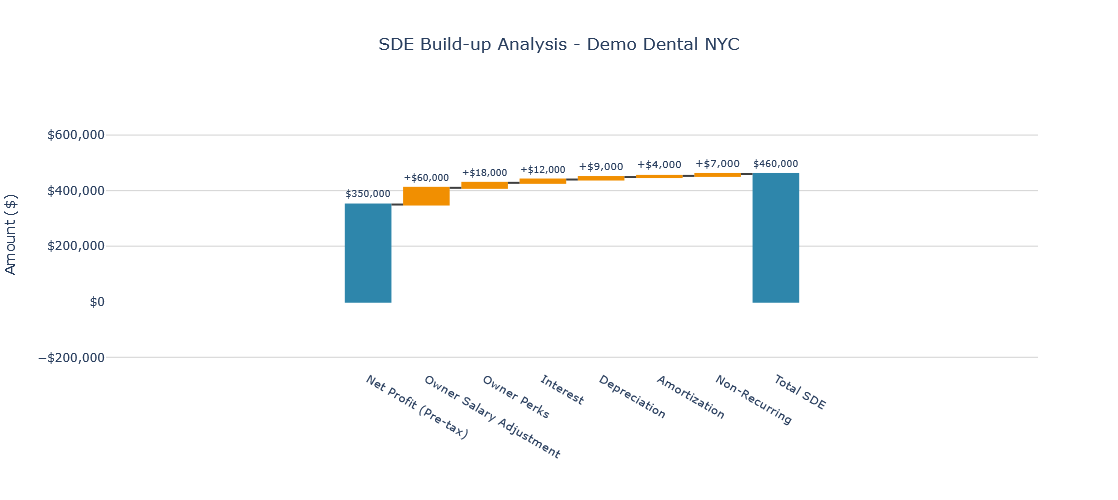

   ‚úÖ SDE Waterfall created

2. Creating Valuation Comparison Chart...
   Purpose: Shows practice value using different methods


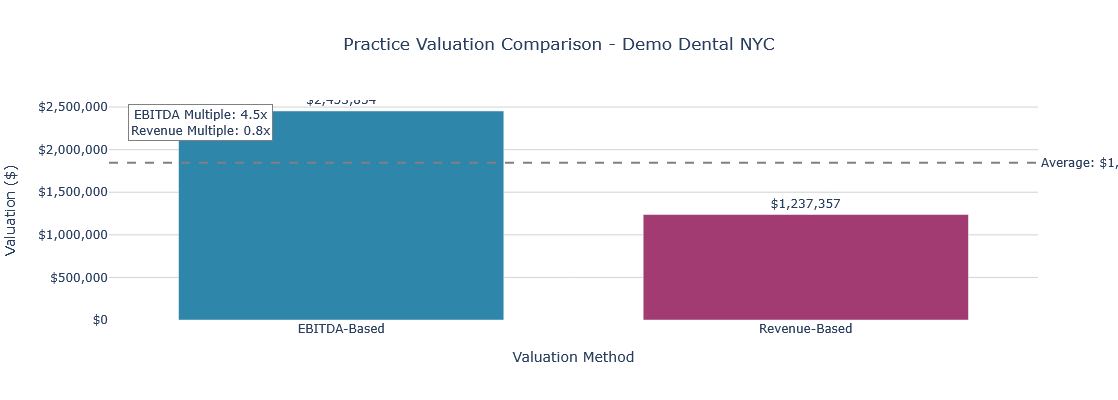

   ‚úÖ Valuation Comparison created

3. Creating Key Metrics Dashboard...
   Purpose: One-page overview of all key metrics


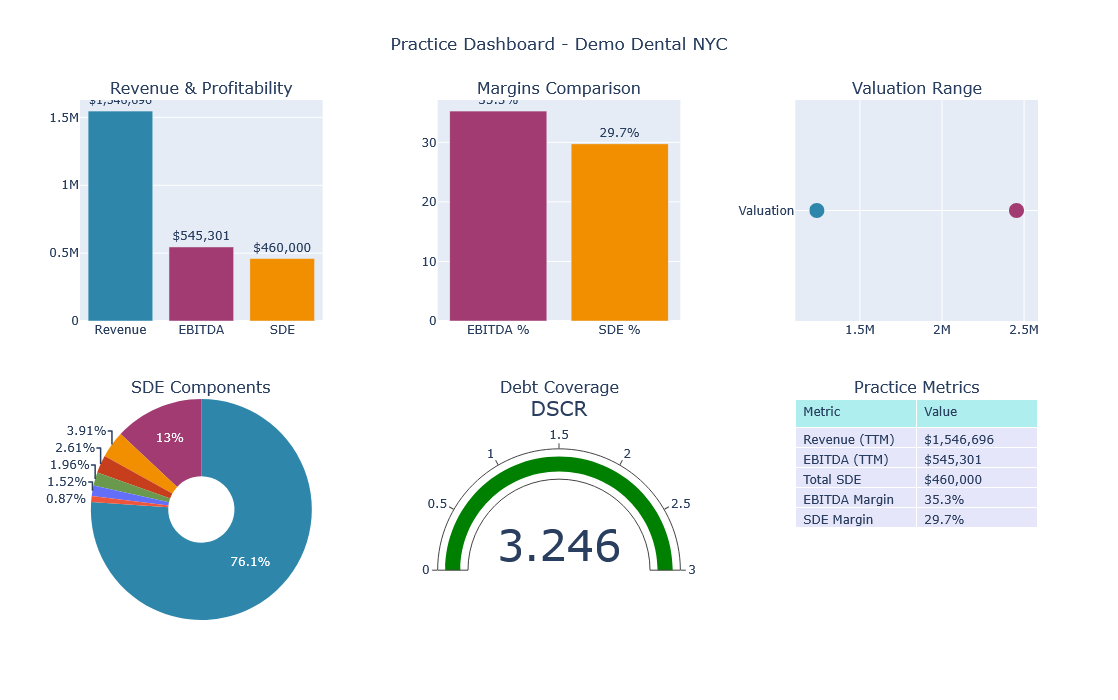

   ‚úÖ Dashboard created

‚úÖ Visualization module ready!

Available visualization types:
  ‚Ä¢ waterfall - SDE build-up analysis (shows profit adjustments)
  ‚Ä¢ bar_comparison - Valuation methods comparison (EBITDA vs Revenue)
  ‚Ä¢ bar_chart - Profitability margins (practice vs industry)
  ‚Ä¢ swot_matrix - SWOT analysis grid (strengths/weaknesses/opportunities/threats)
  ‚Ä¢ gauge_chart - Debt coverage ratio (financial health indicator)
  ‚Ä¢ dashboard - Complete metrics overview (6-panel summary)


In [17]:
# Cell 5: Visualization Generation Functions
# ===========================================

def create_sde_waterfall_chart(practice_data: DentalPracticeData):
    """
    Creates a WATERFALL CHART showing how SDE (Seller's Discretionary Earnings) is calculated.
    
    WHAT IS SDE?
    - SDE is the "true" profit available to a practice owner
    - It's what the owner actually takes home + what they could take home
    - Banks use SDE to determine if a buyer can afford to purchase the practice
    
    WHAT IS A WATERFALL CHART?
    - Shows step-by-step how we get from one number to another
    - Each bar adds to (green) or subtracts from (red) the total
    - Like climbing stairs - each step takes you higher (or lower)
    
    HOW TO READ THIS CHART:
    1. Start with Net Profit (what the tax return shows)
    2. Add back owner's excess salary (owner pays themselves above market rate)
    3. Add back owner perks (personal car, phone, etc. paid by business)
    4. Add back interest (buyer will have different financing)
    5. Add back depreciation (non-cash expense for tax purposes)
    6. Add back amortization (another non-cash expense)
    7. Add back one-time expenses (won't happen again)
    8. Final bar shows Total SDE
    
    WHY THIS MATTERS:
    - Shows the "real" earning power of the practice
    - Helps buyers understand what cash flow they can expect
    - Banks require this for loan approval
    
    Parameters:
    - practice_data: The DentalPracticeData object containing all financial info
    
    Returns:
    - Interactive Plotly chart that users can hover over for details
    """
    
    # Get SDE components from the data
    sde_components = practice_data.data.get("SDE", {})
    
    # Build the waterfall data
    # Each item needs: name, measure type, and value
    waterfall_data = []
    
    # Starting point: Net Profit (what's on the tax return)
    waterfall_data.append({
        'name': 'Net Profit (Pre-tax)',
        'measure': 'absolute',  # This is our starting point
        'value': sde_components.get('Net_Profit_pre_tax', 0),
        'text': f"${sde_components.get('Net_Profit_pre_tax', 0):,.0f}"
    })
    
    # Add each adjustment (these are "add-backs" - amounts we add back to profit)
    adjustments = [
        ('Owner Salary Adjustment', 'Owner_Salary_minus_Market'),  # Owner overpays themselves
        ('Owner Perks', 'Owner_Perks'),                           # Personal expenses in business
        ('Interest', 'Interest'),                                 # Current loan interest
        ('Depreciation', 'Depreciation'),                        # Non-cash tax deduction
        ('Amortization', 'Amortization'),                        # Non-cash tax deduction
        ('Non-Recurring', 'Non_Recurring')                       # One-time expenses
    ]
    
    for display_name, data_key in adjustments:
        value = sde_components.get(data_key, 0)
        if value > 0:  # Only add if there's a value
            waterfall_data.append({
                'name': display_name,
                'measure': 'relative',  # These add to the total
                'value': value,
                'text': f"+${value:,.0f}"
            })
    
    # Final total (this is what the practice really earns)
    waterfall_data.append({
        'name': 'Total SDE',
        'measure': 'total',  # This shows the final sum
        'value': practice_data.data.get('Total_SDE', 0),
        'text': f"${practice_data.data.get('Total_SDE', 0):,.0f}"
    })
    
    # Create the waterfall chart using Plotly
    fig = go.Figure(go.Waterfall(
        name="SDE Build-up",
        orientation="v",  # Vertical bars
        x=[d['name'] for d in waterfall_data],
        y=[d['value'] if d['measure'] != 'total' else None for d in waterfall_data],
        text=[d['text'] for d in waterfall_data],
        textposition="outside",
        measure=[d['measure'] for d in waterfall_data],
        connector={"line": {"color": "rgb(63, 63, 63)"}},  # Lines connecting bars
        increasing={"marker": {"color": VIZ_CONFIG['color_scheme'][2]}},  # Green for additions
        decreasing={"marker": {"color": VIZ_CONFIG['color_scheme'][3]}},  # Red for subtractions
        totals={"marker": {"color": VIZ_CONFIG['color_scheme'][0]}}  # Blue for totals
    ))
    
    # Update layout for better appearance
    fig.update_layout(
        title={
            'text': f"SDE Build-up Analysis - {practice_data.data.get('Clinic', 'Dental Practice')}",
            'x': 0.5,
            'xanchor': 'center'
        },
        yaxis_title="Amount ($)",
        xaxis_title="",
        height=500,
        showlegend=False,
        hovermode='x unified',
        plot_bgcolor='white',
        yaxis=dict(gridcolor='lightgray', tickformat='$,.0f')
    )
    
    return fig

def create_valuation_comparison_chart(practice_data: DentalPracticeData):
    """
    Creates a BAR CHART comparing different methods of valuing the practice.
    
    WHAT IS PRACTICE VALUATION?
    - The estimated selling price of the dental practice
    - Like appraising a house - there are different methods
    - Usually results in a range, not a single number
    
    TWO MAIN VALUATION METHODS:
    1. EBITDA Multiple Method:
       - Takes EBITDA (earnings) √ó industry multiple (typically 3-6x)
       - More accurate because it's based on profitability
       - Preferred by sophisticated buyers
    
    2. Revenue Multiple Method:
       - Takes total revenue √ó industry multiple (typically 0.6-1.0x)
       - Simpler but less accurate
       - Quick "rule of thumb" estimate
    
    HOW TO READ THIS CHART:
    - Two bars showing the practice value using each method
    - Dotted line shows the average of both methods
    - Higher bar = higher valuation
    - The gap between bars shows negotiation range
    
    WHY THIS MATTERS:
    - Sellers want to know what their practice is worth
    - Buyers need to know if the asking price is fair
    - Banks use these multiples for loan decisions
    - Wide gaps suggest more negotiation needed
    
    Parameters:
    - practice_data: The DentalPracticeData object
    
    Returns:
    - Interactive bar chart comparing valuations
    """
    
    # Get valuation data (calculated in the data loading step)
    valuations = {
        'EBITDA-Based': practice_data.metrics.get('Implied_Value_EBITDA', 0),
        'Revenue-Based': practice_data.metrics.get('Implied_Value_Revenue', 0)
    }
    
    # Calculate average for reference (midpoint of the range)
    avg_valuation = sum(valuations.values()) / len(valuations)
    
    # Create bar chart
    fig = go.Figure()
    
    # Add bars for each valuation method
    fig.add_trace(go.Bar(
        x=list(valuations.keys()),
        y=list(valuations.values()),
        text=[f"${v:,.0f}" for v in valuations.values()],  # Show dollar amounts on bars
        textposition='outside',
        marker_color=[VIZ_CONFIG['color_scheme'][0], VIZ_CONFIG['color_scheme'][1]],
        name='Valuation'
    ))
    
    # Add average line for reference (helps show the midpoint)
    fig.add_hline(
        y=avg_valuation, 
        line_dash="dash", 
        line_color="gray",
        annotation_text=f"Average: ${avg_valuation:,.0f}",
        annotation_position="right"
    )
    
    # Update layout
    fig.update_layout(
        title={
            'text': f"Practice Valuation Comparison - {practice_data.data.get('Clinic', 'Dental Practice')}",
            'x': 0.5,
            'xanchor': 'center'
        },
        yaxis_title="Valuation ($)",
        xaxis_title="Valuation Method",
        height=400,
        showlegend=False,
        plot_bgcolor='white',
        yaxis=dict(gridcolor='lightgray', tickformat='$,.0f'),
        bargap=0.3  # Space between bars
    )
    
    # Add annotation box explaining the multiples used
    multiples = practice_data.data.get('Valuation_Multiples', {})
    fig.add_annotation(
        text=f"EBITDA Multiple: {multiples.get('EBITDA_multiple', 0)}x<br>" +
             f"Revenue Multiple: {multiples.get('Revenue_multiple', 0)}x",
        xref="paper", yref="paper",
        x=0.02, y=0.98,
        showarrow=False,
        bgcolor="white",
        bordercolor="gray",
        borderwidth=1
    )
    
    return fig

def create_profitability_margins_chart(practice_data: DentalPracticeData):
    """
    Creates a GROUPED BAR CHART showing profitability margins vs industry averages.
    
    WHAT ARE MARGINS?
    - Margins show what percentage of revenue becomes profit
    - Like a grade on efficiency - higher is better
    - Shows how well the practice controls costs
    
    TWO KEY MARGINS:
    1. EBITDA Margin:
       - (EBITDA √∑ Revenue) √ó 100
       - Shows operating efficiency
       - Typical dental: 30-40%
    
    2. SDE Margin:
       - (SDE √∑ Revenue) √ó 100
       - Shows true owner benefit
       - Typical dental: 25-35%
    
    HOW TO READ THIS CHART:
    - Blue bars = This practice's actual margins
    - Gray bars = Industry average margins
    - Higher bars = better profitability
    - If blue > gray, practice is above average
    
    WHY THIS MATTERS:
    - High margins = well-run practice
    - Low margins = potential problems or opportunities
    - Buyers pay more for high-margin practices
    - Shows where improvements can be made
    
    Parameters:
    - practice_data: The DentalPracticeData object
    
    Returns:
    - Grouped bar chart comparing margins
    """
    
    # Get this practice's margins
    margins = {
        'EBITDA Margin': practice_data.metrics.get('EBITDA_Margin', 0),
        'SDE Margin': practice_data.metrics.get('SDE_Margin', 0)
    }
    
    # Industry benchmarks for comparison (typical dental practice ranges)
    # These are rough averages - actual benchmarks vary by location/specialty
    benchmarks = {
        'EBITDA Margin': 35,  # Industry average EBITDA margin
        'SDE Margin': 30      # Industry average SDE margin
    }
    
    # Create grouped bar chart
    fig = go.Figure()
    
    # This practice's actual margins
    fig.add_trace(go.Bar(
        name='This Practice',
        x=list(margins.keys()),
        y=list(margins.values()),
        text=[f"{v:.1f}%" for v in margins.values()],
        textposition='outside',
        marker_color=VIZ_CONFIG['color_scheme'][0]
    ))
    
    # Industry benchmark margins
    fig.add_trace(go.Bar(
        name='Industry Avg',
        x=list(benchmarks.keys()),
        y=list(benchmarks.values()),
        text=[f"{v:.0f}%" for v in benchmarks.values()],
        textposition='outside',
        marker_color=VIZ_CONFIG['color_scheme'][4],
        opacity=0.6  # Make slightly transparent
    ))
    
    # Update layout
    fig.update_layout(
        title={
            'text': f"Profitability Margins Analysis - {practice_data.data.get('Clinic', 'Dental Practice')}",
            'x': 0.5,
            'xanchor': 'center'
        },
        yaxis_title="Margin (%)",
        xaxis_title="",
        height=400,
        barmode='group',  # Put bars side by side
        plot_bgcolor='white',
        yaxis=dict(gridcolor='lightgray', tickformat='.0f', ticksuffix='%'),
        legend=dict(orientation="h", y=1.1, x=0.5, xanchor='center')
    )
    
    return fig

def create_swot_matrix(practice_data: DentalPracticeData):
    """
    Creates a SWOT ANALYSIS MATRIX - a 2x2 grid showing strategic position.
    
    WHAT IS SWOT?
    S.W.O.T. stands for:
    - Strengths: What the practice does well (internal positive)
    - Weaknesses: What needs improvement (internal negative)
    - Opportunities: External factors that could help growth
    - Threats: External factors that could hurt the practice
    
    HOW TO READ THIS CHART:
    - Top row (Strengths & Weaknesses) = Internal factors (can control)
    - Bottom row (Opportunities & Threats) = External factors (can't control)
    - Left column (Strengths & Opportunities) = Positive factors
    - Right column (Weaknesses & Threats) = Negative factors
    
    WHY THIS MATTERS:
    - Buyers see the full picture of the practice
    - Identifies growth potential (opportunities)
    - Shows risks that need managing (threats)
    - Helps justify the asking price
    - Guides post-acquisition strategy
    
    EXAMPLE INTERPRETATIONS:
    - Many strengths + opportunities = Premium valuation
    - Several weaknesses = Buyer may negotiate lower price
    - Unaddressed threats = Risk factors affecting value
    
    Parameters:
    - practice_data: The DentalPracticeData object
    
    Returns:
    - 2x2 matrix visualization (static matplotlib figure)
    """
    
    swot_data = practice_data.data.get('SWOT', {})
    
    # Create figure with 2x2 subplots (4 quadrants)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'SWOT Analysis - {practice_data.data.get("Clinic", "Dental Practice")}', 
                 fontsize=16, fontweight='bold')
    
    # Define quadrants with their data and colors
    # Green for strengths (positive), Red for weaknesses (negative)
    # Blue for opportunities (potential), Orange for threats (risks)
    quadrants = [
        ('Strengths', swot_data.get('Strengths', []), axes[0, 0], VIZ_CONFIG['color_scheme'][2]),
        ('Weaknesses', swot_data.get('Weaknesses', []), axes[0, 1], VIZ_CONFIG['color_scheme'][3]),
        ('Opportunities', swot_data.get('Opportunities', []), axes[1, 0], VIZ_CONFIG['color_scheme'][1]),
        ('Threats', swot_data.get('Threats', []), axes[1, 1], VIZ_CONFIG['color_scheme'][0])
    ]
    
    # Fill each quadrant
    for title, items, ax, color in quadrants:
        # Set background color (light version with transparency)
        ax.set_facecolor(color + '20')  # Add transparency
        
        # Add quadrant title
        ax.text(0.5, 0.9, title, fontsize=14, fontweight='bold',
                ha='center', transform=ax.transAxes)
        
        # Add items as bullet points
        y_position = 0.7
        for item in items[:5]:  # Limit to 5 items per quadrant for readability
            ax.text(0.1, y_position, f'‚Ä¢ {item}', fontsize=11,
                   transform=ax.transAxes, wrap=True)
            y_position -= 0.15
        
        # Remove axes for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add colored border
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(2)
    
    plt.tight_layout()
    return fig

def create_debt_coverage_gauge(practice_data: DentalPracticeData):
    """
    Creates a GAUGE CHART showing Debt Service Coverage Ratio (DSCR).
    
    WHAT IS DSCR?
    - Debt Service Coverage Ratio
    - Formula: EBITDA √∑ Annual Debt Payments
    - Shows if practice generates enough cash to pay its loans
    - Banks require minimum DSCR of 1.2-1.25 for loans
    
    HOW TO READ THIS GAUGE:
    - Red Zone (0-1.0): DANGER - Cannot cover debt payments
    - Yellow Zone (1.0-1.25): CAUTION - Tight coverage, risky
    - Green Zone (1.25+): GOOD - Comfortable debt coverage
    
    WHAT THE NUMBERS MEAN:
    - DSCR = 1.0: Breaking even on debt (no cushion)
    - DSCR = 1.25: Have 25% cushion above debt payments
    - DSCR = 2.0: Generate 2x the cash needed for debt
    
    WHY THIS MATTERS:
    - Banks won't lend if DSCR < 1.2
    - Low DSCR = practice is overleveraged
    - High DSCR = room for more debt or distributions
    - Critical metric for buyer financing approval
    
    BUYER IMPLICATIONS:
    - DSCR < 1.0: Need to inject cash or renegotiate debt
    - DSCR 1.0-1.25: Limited cash for owner or growth
    - DSCR > 1.25: Healthy cash flow after debt service
    
    Parameters:
    - practice_data: The DentalPracticeData object
    
    Returns:
    - Gauge chart visualization (like a speedometer)
    """
    
    dscr = practice_data.metrics.get('DSCR', 0)
    
    # Create gauge chart
    fig = go.Figure(go.Indicator(
        mode="gauge+number+delta",
        value=dscr,
        title={'text': "Debt Service Coverage Ratio"},
        delta={'reference': 1.25, 'relative': False},  # Compare to healthy threshold
        gauge={
            'axis': {'range': [0, 3], 'tickwidth': 1},
            'bar': {'color': "darkblue"},  # The needle color
            'steps': [  # Background zones
                {'range': [0, 1], 'color': "lightgray"},        # Can't cover debt
                {'range': [1, 1.25], 'color': "lightyellow"},   # Tight coverage
                {'range': [1.25, 3], 'color': "lightgreen"}     # Healthy coverage
            ],
            'threshold': {  # Red line at minimum viable level
                'line': {'color': "red", 'width': 4},
                'thickness': 0.75,
                'value': 1  # Minimum viable DSCR
            }
        }
    ))
    
    # Update layout
    fig.update_layout(
        height=400,
        title={
            'text': f"Debt Coverage Analysis - {practice_data.data.get('Clinic', 'Dental Practice')}",
            'x': 0.5,
            'xanchor': 'center'
        }
    )
    
    # Add interpretation text based on DSCR value
    if dscr < 1:
        interpretation = "‚ö†Ô∏è Warning: Insufficient cash flow to cover debt payments"
    elif dscr < 1.25:
        interpretation = "‚ö° Caution: Tight debt coverage - limited margin for error"
    else:
        interpretation = "‚úÖ Healthy: Strong debt coverage with comfortable cushion"
    
    fig.add_annotation(
        text=interpretation,
        xref="paper", yref="paper",
        x=0.5, y=-0.1,
        showarrow=False,
        font=dict(size=12)
    )
    
    return fig

def create_key_metrics_dashboard(practice_data: DentalPracticeData):
    """
    Creates a COMPREHENSIVE DASHBOARD with 6 panels of key information.
    
    WHAT IS THIS DASHBOARD?
    - A one-page overview of all critical practice metrics
    - Like a car dashboard - shows everything at a glance
    - Used for initial assessment and presentations
    
    THE 6 PANELS:
    1. Revenue & Profitability: Size and earnings of practice
    2. Margins Comparison: Efficiency vs industry
    3. Valuation Range: What the practice is worth
    4. SDE Components: Where the profit comes from
    5. Debt Coverage: Financial health indicator
    6. Practice Metrics: Key operational data
    
    HOW TO USE THIS:
    - First thing to show potential buyers
    - Quick health check of the practice
    - Identifies areas needing deeper analysis
    - Executive summary for decision makers
    
    WHY THIS MATTERS:
    - Saves time by showing everything at once
    - Helps identify red flags quickly
    - Provides context for detailed discussions
    - Professional presentation for stakeholders
    
    Parameters:
    - practice_data: The DentalPracticeData object
    
    Returns:
    - Multi-panel Plotly dashboard
    """
    
    # Create subplots with different chart types
    fig = make_subplots(
        rows=2, cols=3,  # 2 rows, 3 columns = 6 panels
        subplot_titles=(
            'Revenue & Profitability',  # Shows practice size
            'Margins Comparison',        # Shows efficiency
            'Valuation Range',          # Shows worth
            'SDE Components',           # Shows profit makeup
            'Debt Coverage',            # Shows financial health
            'Practice Metrics'          # Shows key numbers
        ),
        specs=[  # Define what type of chart goes in each position
            [{'type': 'bar'}, {'type': 'bar'}, {'type': 'scatter'}],
            [{'type': 'pie'}, {'type': 'indicator'}, {'type': 'table'}]
        ],
        vertical_spacing=0.15,
        horizontal_spacing=0.12
    )
    
    # 1. Revenue & Profitability bars (top-left)
    # Shows the cascade from revenue ‚Üí EBITDA ‚Üí SDE
    fig.add_trace(
        go.Bar(
            x=['Revenue', 'EBITDA', 'SDE'],
            y=[
                practice_data.data.get('Revenue_Trailing12', 0),
                practice_data.data.get('EBITDA_Trailing12', 0),
                practice_data.data.get('Total_SDE', 0)
            ],
            text=[
                f"${practice_data.data.get('Revenue_Trailing12', 0):,.0f}",
                f"${practice_data.data.get('EBITDA_Trailing12', 0):,.0f}",
                f"${practice_data.data.get('Total_SDE', 0):,.0f}"
            ],
            textposition='outside',
            marker_color=VIZ_CONFIG['color_scheme'][:3]
        ),
        row=1, col=1
    )
    
    # 2. Margins comparison (top-middle)
    # Shows profitability percentages
    fig.add_trace(
        go.Bar(
            x=['EBITDA %', 'SDE %'],
            y=[
                practice_data.metrics.get('EBITDA_Margin', 0),
                practice_data.metrics.get('SDE_Margin', 0)
            ],
            text=[
                f"{practice_data.metrics.get('EBITDA_Margin', 0):.1f}%",
                f"{practice_data.metrics.get('SDE_Margin', 0):.1f}%"
            ],
            textposition='outside',
            marker_color=[VIZ_CONFIG['color_scheme'][1], VIZ_CONFIG['color_scheme'][2]]
        ),
        row=1, col=2
    )
    
    # 3. Valuation range (top-right)
    # Shows the spread between valuation methods
    valuations = [
        practice_data.metrics.get('Implied_Value_Revenue', 0),
        practice_data.metrics.get('Implied_Value_EBITDA', 0)
    ]
    fig.add_trace(
        go.Scatter(
            x=valuations,
            y=['Valuation', 'Valuation'],
            mode='markers',
            marker=dict(size=15, color=VIZ_CONFIG['color_scheme'][:2]),
            text=[f"Revenue: ${valuations[0]:,.0f}", f"EBITDA: ${valuations[1]:,.0f}"],
            showlegend=False
        ),
        row=1, col=3
    )
    
    # 4. SDE Components pie chart (bottom-left)
    # Shows what makes up the SDE
    sde_components = practice_data.data.get('SDE', {})
    fig.add_trace(
        go.Pie(
            labels=list(sde_components.keys()),
            values=list(sde_components.values()),
            hole=0.3,  # Donut chart
            marker_colors=VIZ_CONFIG['color_scheme']
        ),
        row=2, col=1
    )
    
    # 5. Debt Coverage gauge (bottom-middle)
    # Quick visual of DSCR health
    dscr = practice_data.metrics.get('DSCR', 0)
    fig.add_trace(
        go.Indicator(
            mode="number+gauge",
            value=dscr,
            gauge={'axis': {'range': [0, 3]},
                   'bar': {'color': "green" if dscr > 1.25 else "yellow" if dscr > 1 else "red"}},
            title={'text': "DSCR"}
        ),
        row=2, col=2
    )
    
    # 6. Key metrics table (bottom-right)
    # Quick reference for important numbers
    summary_df = practice_data.get_summary()
    fig.add_trace(
        go.Table(
            header=dict(values=['Metric', 'Value'],
                       fill_color='paleturquoise',
                       align='left'),
            cells=dict(values=[summary_df['Metric'][:5], summary_df['Value'][:5]],
                      fill_color='lavender',
                      align='left')
        ),
        row=2, col=3
    )
    
    # Update overall layout
    fig.update_layout(
        title={
            'text': f"Practice Dashboard - {practice_data.data.get('Clinic', 'Dental Practice')}",
            'x': 0.5,
            'xanchor': 'center'
        },
        height=700,
        showlegend=False
    )
    
    return fig

def generate_visualization(viz_type: str, practice_data: DentalPracticeData):
    """
    Main routing function that generates any visualization based on type.
    This is the function you call when you need a specific chart.
    
    HOW TO USE:
    figure = generate_visualization('waterfall', practice_data)
    figure.show()  # Display the chart
    
    AVAILABLE VISUALIZATION TYPES:
    - 'waterfall': SDE build-up from Net Profit
    - 'bar_comparison': Valuation methods comparison  
    - 'bar_chart': Profitability margins vs industry
    - 'swot_matrix': 2x2 SWOT analysis grid
    - 'gauge_chart': Debt coverage ratio gauge
    - 'dashboard': Complete 6-panel overview
    
    Parameters:
    - viz_type: String specifying which chart to create
    - practice_data: The DentalPracticeData object with all info
    
    Returns:
    - Figure object that can be displayed or saved
    - Returns None if there's an error
    """
    
    # Map visualization types to their creation functions
    viz_functions = {
        'waterfall': create_sde_waterfall_chart,
        'bar_comparison': create_valuation_comparison_chart,
        'bar_chart': create_profitability_margins_chart,
        'swot_matrix': create_swot_matrix,
        'gauge_chart': create_debt_coverage_gauge,
        'dashboard': create_key_metrics_dashboard
    }
    
    # Get the appropriate function for the requested type
    viz_function = viz_functions.get(viz_type)
    
    if viz_function:
        try:
            return viz_function(practice_data)
        except Exception as e:
            print(f"‚ùå Error creating {viz_type}: {str(e)}")
            return None
    else:
        print(f"‚ö†Ô∏è Unknown visualization type: {viz_type}")
        return None

# ===================================
# TEST VISUALIZATIONS
# ===================================

# Make sure we have practice data loaded
if 'practice_data' not in locals():
    print("‚ö†Ô∏è Loading practice data first...")
    practice_data = DentalPracticeData(json_path="demo_clinic.json")

print("="*60)
print("üé® TESTING VISUALIZATION FUNCTIONS")
print("="*60)

# Test 1: SDE Waterfall Chart
# This shows how profit builds up to SDE
print("\n1. Creating SDE Waterfall Chart...")
print("   Purpose: Shows step-by-step how Net Profit becomes SDE")
fig1 = create_sde_waterfall_chart(practice_data)
if fig1:
    fig1.show()
    print("   ‚úÖ SDE Waterfall created")

# Test 2: Valuation Comparison
# This compares different ways to value the practice
print("\n2. Creating Valuation Comparison Chart...")
print("   Purpose: Shows practice value using different methods")
fig2 = create_valuation_comparison_chart(practice_data)
if fig2:
    fig2.show()
    print("   ‚úÖ Valuation Comparison created")

# Test 3: Dashboard
# This gives the complete overview in one view
print("\n3. Creating Key Metrics Dashboard...")
print("   Purpose: One-page overview of all key metrics")
fig3 = create_key_metrics_dashboard(practice_data)
if fig3:
    fig3.show()
    print("   ‚úÖ Dashboard created")

print("\n" + "="*60)
print("‚úÖ Visualization module ready!")
print("\nAvailable visualization types:")
print("  ‚Ä¢ waterfall - SDE build-up analysis (shows profit adjustments)")
print("  ‚Ä¢ bar_comparison - Valuation methods comparison (EBITDA vs Revenue)")
print("  ‚Ä¢ bar_chart - Profitability margins (practice vs industry)")
print("  ‚Ä¢ swot_matrix - SWOT analysis grid (strengths/weaknesses/opportunities/threats)")
print("  ‚Ä¢ gauge_chart - Debt coverage ratio (financial health indicator)")
print("  ‚Ä¢ dashboard - Complete metrics overview (6-panel summary)")
print("="*60)


üöÄ DENTAL PRACTICE VALUATION Q&A PIPELINE READY!

üìå DEMO: Processing a sample question...
Question: 'What is the SDE for this practice and explain how it's calculated?'
----------------------------------------------------------------------

ü¶∑ DENTAL PRACTICE VALUATION Q&A SYSTEM
‚è∞ Timestamp: 2025-08-07 18:36:19
üìù Question: What is the SDE for this practice and explain how it's calculated?
----------------------------------------------------------------------
üìä Category detected: SDE
ü§ñ Getting AI analysis...
ü§ñ Calling DeepSeek API...
‚úÖ Response received!
üìà Creating 1 visualization(s)...
   - Creating SDE Build-up Analysis...


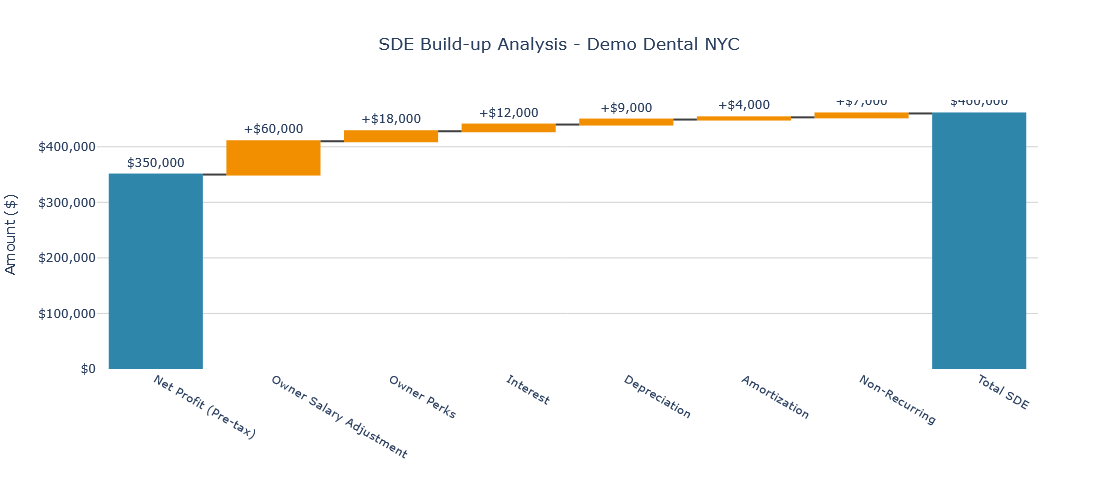

----------------------------------------------------------------------
‚úÖ Question processed successfully!



### üìù Question
**What is the SDE for this practice and explain how it's calculated?**

---

### üìä Analysis Category
`SDE`

---

### üí° Answer
### **Seller's Discretionary Earnings (SDE) Analysis for Demo Dental NYC**  

#### **1. Definition of SDE**  
Seller's Discretionary Earnings (SDE) represents the total financial benefit a single owner-operator derives from the practice, including both profits and discretionary expenses. It is a key metric for valuing small to mid-sized dental practices.  

#### **2. SDE Calculation Breakdown**  
The SDE for **Demo Dental NYC** is **$460,000**, calculated as follows:  

| **Component**                     | **Amount ($)** | **Type**  | **Justification** |
|-----------------------------------|---------------|-----------|------------------|
| Net Profit (Pre-Tax)              | 350,000       | Cash      | Base accounting profit before tax adjustments. |
| + Owner Salary Above Market       | 60,000        | Cash      | Portion of the owner's salary exceeding fair-market compensation for a dentist in NYC. |
| + Owner Perks                     | 18,000        | Cash      | Clinic-paid personal expenses (auto, phone, family health insurance). |
| + Interest Expense                | 12,000        | Cash      | Financing costs‚Äîassumed refinanced by buyer. |
| + Depreciation                    | 9,000         | Non-Cash  | Non-cash accounting expense (equipment wear & tear). |
| + Amortization                    | 4,000         | Non-Cash  | Non-cash expense (prior goodwill amortization). |
| + Non-Recurring Expense           | 7,000         | Cash      | One-time legal settlement (FY 2024). |
| **Total SDE**                     | **460,000**   |           | **Sum of all adjustments to net profit.** |

#### **3. Key Observations**  
- **Cash vs. Non-Cash Adjustments:**  
  - **Cash Addbacks ($97,000 total):**  
    - Owner salary above market ($60K)  
    - Owner perks ($18K)  
    - Interest ($12K)  
    - Non-recurring expense ($7K)  
  - **Non-Cash Addbacks ($13,000 total):**  
    - Depreciation ($9K)  
    - Amortization ($4K)  

- **SDE Margin:**  
  - **29.7%** ($460K SDE / $1,546,696 Revenue)  
  - **Industry Benchmark:** Typically 25-40% for well-run FFS practices. Demo Dental is in the upper range, indicating strong profitability.  

#### **4. Visualizations That Would Help**  
To better illustrate the SDE composition, the following visuals would be useful:  
1. **SDE Breakdown Pie Chart** ‚Äì Showing the contribution of each addback component.  
2. **Cash vs. Non-Cash Addbacks Bar Chart** ‚Äì Highlighting the split between real cash savings and accounting adjustments.  
3. **SDE Margin Trend (if historical data available)** ‚Äì To assess profitability consistency.  

#### **5. Valuation Implications**  
- **SDE-Based Valuation:** Using a typical multiple of **4.0x‚Äì5.0x SDE**, the practice could be valued between **$1.84M‚Äì$2.3M**.  
- **EBITDA vs. SDE:** Since SDE includes owner compensation, it is typically higher than EBITDA ($545K vs. $460K).  

#### **Conclusion**  
Demo Dental NYC generates a strong **$460K SDE**, supported by high FFS revenue and efficient operations. The addbacks are well-justified, with a healthy mix of cash and non-cash adjustments. Buyers should focus on maintaining the high SDE margin while exploring growth opportunities (e.g., expanded hours, implant services).  

Would you like further breakdowns on valuation multiples or debt service coverage?

---

### üìà Visualizations Generated
- **SDE Build-up Analysis**: Shows how we get from Net Profit to SDE

---
*Generated: 2025-08-07 18:36:19*


üìö AVAILABLE FUNCTIONS:

1. process_question_with_visualizations()
   - Main pipeline function
   - Takes question ‚Üí returns answer + visualizations
   
2. run_interactive_qa_session()
   - Interactive mode for multiple questions
   - Type questions one at a time
   
3. batch_process_questions()
   - Process multiple questions at once
   - Generate comprehensive reports

4. Common question examples:
   - "What is this practice worth?"
   - "Can the practice support its debt?"
   - "How does profitability compare to industry?"
   - "What are the key risks and opportunities?"
   - "Calculate the buyer's after-tax cash flow"


üí° TIP: To start an interactive session, run:
   run_interactive_qa_session(practice_data)

‚úÖ System fully integrated and ready for use!


In [19]:
# Cell 6: Main Pipeline Integration
# ===================================
# This cell brings everything together into a complete Q&A system

def process_question_with_visualizations(
    question: str, 
    practice_data: DentalPracticeData,
    show_visualizations: bool = True,
    save_outputs: bool = False,
    output_dir: str = "valuation_outputs"
) -> dict:
    """
    MAIN PIPELINE FUNCTION - This is the complete system in one function.
    Takes a question and returns an answer with relevant visualizations.
    
    WHAT THIS DOES:
    1. Accepts a question about the dental practice
    2. Categorizes the question type
    3. Gets an intelligent answer from the LLM
    4. Creates relevant visualizations
    5. Optionally saves everything to files
    
    Parameters:
    - question: The user's question (string)
    - practice_data: The loaded practice data object
    - show_visualizations: Whether to display charts (default True)
    - save_outputs: Whether to save results to files (default False)
    - output_dir: Directory to save outputs if save_outputs=True
    
    Returns:
    - Dictionary containing:
      - 'question': Original question
      - 'category': Detected question type
      - 'answer': LLM's detailed response
      - 'visualizations': List of generated charts
      - 'timestamp': When the question was processed
      - 'files_saved': List of saved file paths (if save_outputs=True)
    """
    
    import os
    from datetime import datetime
    
    # Record when this question was processed
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    print("\n" + "="*70)
    print("ü¶∑ DENTAL PRACTICE VALUATION Q&A SYSTEM")
    print("="*70)
    print(f"‚è∞ Timestamp: {timestamp}")
    print(f"üìù Question: {question}")
    print("-"*70)
    
    # Step 1: Categorize the question
    category = categorize_question(question)
    print(f"üìä Category detected: {category}")
    
    # Step 2: Get LLM answer
    print("ü§ñ Getting AI analysis...")
    prompt = create_context_prompt(practice_data, question, category)
    answer = call_llm(prompt)
    
    # Step 3: Get visualization recommendations
    viz_recommendations = get_visualization_recommendations(question, category, practice_data)
    
    # Step 4: Generate visualizations
    generated_visualizations = []
    print(f"üìà Creating {len(viz_recommendations)} visualization(s)...")
    
    for viz_rec in viz_recommendations:
        viz_type = viz_rec['type']
        print(f"   - Creating {viz_rec['title']}...")
        
        try:
            fig = generate_visualization(viz_type, practice_data)
            if fig:
                generated_visualizations.append({
                    'type': viz_type,
                    'title': viz_rec['title'],
                    'description': viz_rec['description'],
                    'figure': fig
                })
                
                # Display the visualization if requested
                if show_visualizations:
                    if hasattr(fig, 'show'):  # Plotly figure
                        fig.show()
                    else:  # Matplotlib figure
                        plt.show()
                        
        except Exception as e:
            print(f"   ‚ö†Ô∏è Could not create {viz_type}: {str(e)}")
    
    # Step 5: Save outputs if requested
    files_saved = []
    if save_outputs:
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Generate safe filename from timestamp
        safe_timestamp = timestamp.replace(":", "-").replace(" ", "_")
        
        # Save the Q&A as a markdown file
        qa_filename = os.path.join(output_dir, f"qa_{safe_timestamp}.md")
        with open(qa_filename, 'w') as f:
            f.write(f"# Dental Practice Valuation Q&A\n\n")
            f.write(f"**Practice:** {practice_data.data.get('Clinic', 'Unknown')}\n")
            f.write(f"**Date:** {timestamp}\n\n")
            f.write(f"## Question\n{question}\n\n")
            f.write(f"**Category:** {category}\n\n")
            f.write(f"## Answer\n{answer}\n\n")
            f.write(f"## Visualizations Created\n")
            for viz in generated_visualizations:
                f.write(f"- {viz['title']}: {viz['description']}\n")
        
        files_saved.append(qa_filename)
        print(f"   ‚úÖ Saved Q&A to: {qa_filename}")
        
        # Save visualizations
        for i, viz in enumerate(generated_visualizations):
            fig = viz['figure']
            viz_filename = os.path.join(output_dir, f"viz_{i+1}_{viz['type']}_{safe_timestamp}")
            
            if hasattr(fig, 'write_html'):  # Plotly figure
                fig.write_html(f"{viz_filename}.html")
                files_saved.append(f"{viz_filename}.html")
                print(f"   ‚úÖ Saved {viz['title']} to: {viz_filename}.html")
            else:  # Matplotlib figure
                fig.savefig(f"{viz_filename}.png", dpi=150, bbox_inches='tight')
                files_saved.append(f"{viz_filename}.png")
                print(f"   ‚úÖ Saved {viz['title']} to: {viz_filename}.png")
    
    # Compile results
    result = {
        'question': question,
        'category': category,
        'answer': answer,
        'visualizations': generated_visualizations,
        'timestamp': timestamp,
        'files_saved': files_saved
    }
    
    print("-"*70)
    print("‚úÖ Question processed successfully!")
    print("="*70)
    
    return result

def display_formatted_answer(result: dict):
    """
    Displays the Q&A result in a nicely formatted way for Jupyter notebooks.
    
    Parameters:
    - result: The dictionary returned by process_question_with_visualizations
    
    This creates a clean, professional display of the answer with:
    - Formatted markdown
    - Highlighted key metrics
    - Clear sections
    """
    
    from IPython.display import display, Markdown
    
    # Build formatted markdown output
    output = f"""
### üìù Question
**{result['question']}**

---

### üìä Analysis Category
`{result['category']}`

---

### üí° Answer
{result['answer']}

---

### üìà Visualizations Generated
"""
    
    for viz in result['visualizations']:
        output += f"- **{viz['title']}**: {viz['description']}\n"
    
    if result['files_saved']:
        output += f"\n---\n### üíæ Files Saved\n"
        for file in result['files_saved']:
            output += f"- `{file}`\n"
    
    output += f"\n---\n*Generated: {result['timestamp']}*"
    
    display(Markdown(output))

def run_interactive_qa_session(practice_data: DentalPracticeData):
    """
    Runs an interactive Q&A session where users can ask multiple questions.
    This is useful for demonstrations or training.
    
    Parameters:
    - practice_data: The loaded practice data
    
    How it works:
    - Prompts user for questions
    - Processes each question
    - Type 'quit' or 'exit' to stop
    """
    
    print("\n" + "="*70)
    print("ü¶∑ INTERACTIVE DENTAL PRACTICE VALUATION Q&A")
    print("="*70)
    print(f"Practice: {practice_data.data.get('Clinic', 'Unknown')}")
    print("Type 'quit' or 'exit' to end the session")
    print("Type 'help' for example questions")
    print("="*70)
    
    # Example questions for users
    example_questions = [
        "What is the SDE for this practice and how is it calculated?",
        "What is this practice worth based on the valuation multiples?",
        "How do the margins compare to industry standards?",
        "Can this practice afford its debt payments?",
        "What are the main strengths and weaknesses?",
        "What's the after-tax cash flow for a buyer?",
        "Explain the EBITDA and how it relates to practice value",
        "What growth opportunities exist for this practice?"
    ]
    
    while True:
        print("\n")
        question = input("Enter your question (or 'help' for examples): ").strip()
        
        if question.lower() in ['quit', 'exit']:
            print("\nüëã Thank you for using the Dental Practice Valuation Q&A System!")
            break
        
        elif question.lower() == 'help':
            print("\nüìö Example Questions:")
            for i, q in enumerate(example_questions, 1):
                print(f"   {i}. {q}")
            continue
        
        elif question == "":
            print("‚ö†Ô∏è Please enter a question.")
            continue
        
        else:
            # Process the question
            result = process_question_with_visualizations(
                question=question,
                practice_data=practice_data,
                show_visualizations=True,
                save_outputs=False  # Change to True to save files
            )
            
            # Display formatted answer
            display_formatted_answer(result)

def batch_process_questions(
    questions: list,
    practice_data: DentalPracticeData,
    save_report: bool = True
) -> list:
    """
    Processes multiple questions at once and optionally creates a report.
    Useful for generating comprehensive practice assessments.
    
    Parameters:
    - questions: List of questions to process
    - practice_data: The loaded practice data
    - save_report: Whether to save a combined report
    
    Returns:
    - List of results for each question
    
    Use case:
    - Generate a standard report for every practice
    - Answer common buyer questions all at once
    - Create documentation for due diligence
    """
    
    results = []
    
    print("\n" + "="*70)
    print("üìã BATCH PROCESSING QUESTIONS")
    print("="*70)
    print(f"Processing {len(questions)} questions...")
    
    for i, question in enumerate(questions, 1):
        print(f"\n[{i}/{len(questions)}] Processing: {question[:50]}...")
        
        result = process_question_with_visualizations(
            question=question,
            practice_data=practice_data,
            show_visualizations=False,  # Don't show each chart
            save_outputs=False  # We'll save combined report instead
        )
        results.append(result)
    
    if save_report:
        # Create comprehensive report
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        report_filename = f"valuation_report_{timestamp}.md"
        
        with open(report_filename, 'w') as f:
            f.write(f"# Dental Practice Valuation Report\n\n")
            f.write(f"**Practice:** {practice_data.data.get('Clinic', 'Unknown')}\n")
            f.write(f"**Report Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            f.write(f"---\n\n")
            
            # Add summary metrics
            f.write(f"## Executive Summary\n\n")
            f.write(f"- **Revenue (TTM):** ${practice_data.data.get('Revenue_Trailing12', 0):,.0f}\n")
            f.write(f"- **EBITDA (TTM):** ${practice_data.data.get('EBITDA_Trailing12', 0):,.0f}\n")
            f.write(f"- **Total SDE:** ${practice_data.data.get('Total_SDE', 0):,.0f}\n")
            f.write(f"- **EBITDA Margin:** {practice_data.metrics.get('EBITDA_Margin', 0):.1f}%\n")
            f.write(f"- **Implied Value (EBITDA):** ${practice_data.metrics.get('Implied_Value_EBITDA', 0):,.0f}\n")
            f.write(f"\n---\n\n")
            
            # Add each Q&A
            for i, result in enumerate(results, 1):
                f.write(f"## Question {i}\n\n")
                f.write(f"**{result['question']}**\n\n")
                f.write(f"### Answer\n{result['answer']}\n\n")
                f.write(f"---\n\n")
        
        print(f"\n‚úÖ Report saved to: {report_filename}")
    
    print("\n" + "="*70)
    print(f"‚úÖ Processed {len(results)} questions successfully!")
    
    return results

# ===================================
# DEMONSTRATION AND TESTING
# ===================================

# Make sure we have practice data loaded
if 'practice_data' not in locals():
    print("‚ö†Ô∏è Loading practice data first...")
    practice_data = DentalPracticeData(json_path="demo_clinic.json")

print("\n" + "="*70)
print("üöÄ DENTAL PRACTICE VALUATION Q&A PIPELINE READY!")
print("="*70)

# Demonstrate with a sample question
demo_question = "What is the SDE for this practice and explain how it's calculated?"

print("\nüìå DEMO: Processing a sample question...")
print(f"Question: '{demo_question}'")
print("-"*70)

# Process the question
demo_result = process_question_with_visualizations(
    question=demo_question,
    practice_data=practice_data,
    show_visualizations=True,
    save_outputs=False  # Set to True to save files
)

# Display the formatted answer
display_formatted_answer(demo_result)

# Show available functions
print("\n" + "="*70)
print("üìö AVAILABLE FUNCTIONS:")
print("="*70)
print("""
1. process_question_with_visualizations()
   - Main pipeline function
   - Takes question ‚Üí returns answer + visualizations
   
2. run_interactive_qa_session()
   - Interactive mode for multiple questions
   - Type questions one at a time
   
3. batch_process_questions()
   - Process multiple questions at once
   - Generate comprehensive reports

4. Common question examples:
   - "What is this practice worth?"
   - "Can the practice support its debt?"
   - "How does profitability compare to industry?"
   - "What are the key risks and opportunities?"
   - "Calculate the buyer's after-tax cash flow"
""")

print("\nüí° TIP: To start an interactive session, run:")
print("   run_interactive_qa_session(practice_data)")
print("\n‚úÖ System fully integrated and ready for use!")
print("="*70)